In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/test.csv
/content/train.csv
/content/.config/gce
/content/.config/.last_opt_in_prompt.yaml
/content/.config/default_configs.db
/content/.config/active_config
/content/.config/config_sentinel
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/logs/2023.11.30/14.27.39.135357.log
/content/.config/logs/2023.11.30/14.21.35.326164.log
/content/.config/logs/2023.11.30/14.27.28.291696.log
/content/.config/logs/2023.11.30/14.24.29.678035.log
/content/.config/logs/2023.11.30/14.27.38.299831.log
/content/.config/logs/2023.11.30/14.24.39.396978.log
/content/.config/configurations/config_default
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv


In [58]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

import numpy as np
import pandas as pd
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf
from sklearn.metrics import confusion_matrix
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**LOADING THE DATA:**

In [5]:
max_len = 36
train_data = pd.read_csv('/content/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('/content/test.csv',usecols=['id','text'])

In [6]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_data.shape

(7613, 3)

In [9]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)

In [10]:
train_cleaned_data = text_preprocessing(train_data,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [11]:
train_cleaned_data[train_cleaned_data.target == 0].head(5)

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0


In [12]:
train_data = train_cleaned_data.copy()
train_data.head(10) # 1 = disaster tweet, 0 = non-disaster tweet

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,im on top of the hill and i can see a fire in ...,1
8,14,theres an emergency evacuation happening now i...,1
9,15,im afraid that the tornado is coming to our area,1


**WORD CLOUD:**

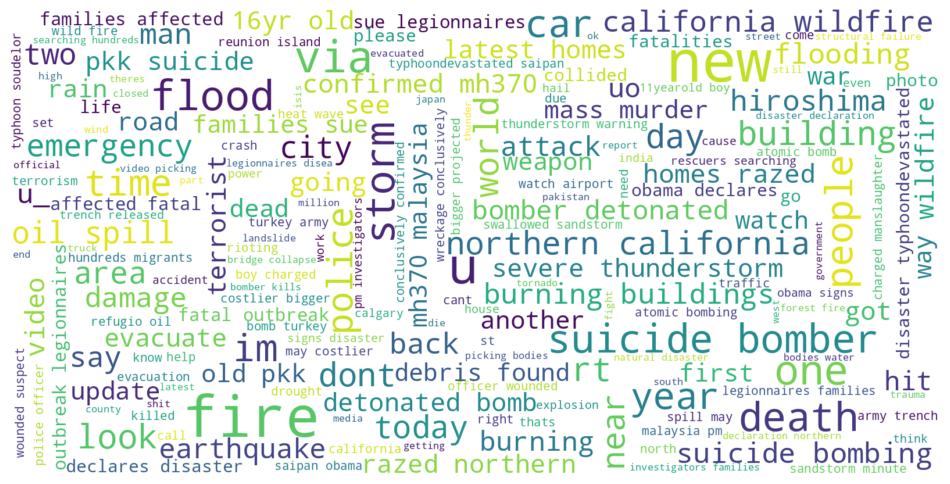

In [13]:
stop_words = set(stopwords.words('english'))
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


disaster_tweets = train_data[train_data.target == 1]
disaster_string = []

for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

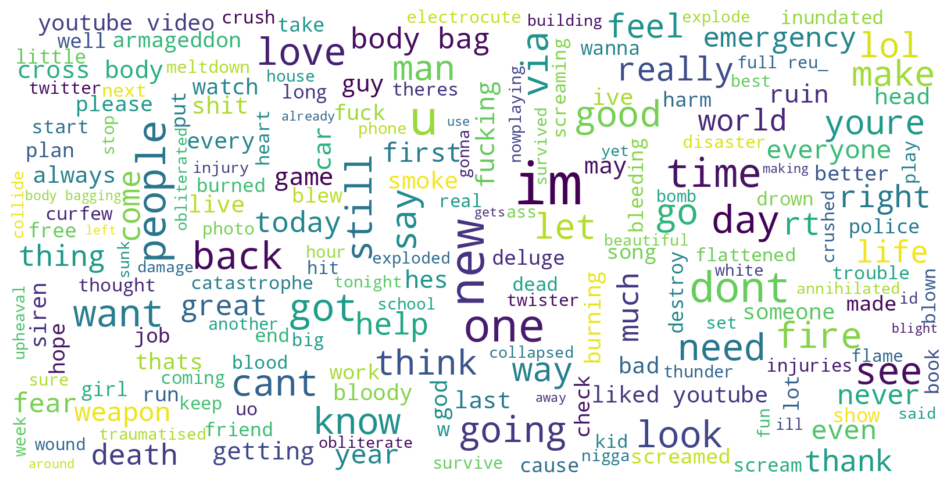

In [14]:
# Positive tweets wordcloud
formal_tweets = train_data[train_data.target == 0]
formal_string = []

for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Even here we can see some dramatic words that could be linked to disasters e.g., "annihilated", "annihilated", "damage", "explode", "armageddon". Let's take a look at some of these tweets:

In [15]:
formal_tweets[formal_tweets['text'].str.contains('armageddon')]['text'].head(5).apply(print)

pbban temporary300 avysss armageddon kill flags fast xp reason
pbban temporary300 russaky89 armageddon kill flags fast xp reason
official vid doublecups httpstcolfkmtzaekk trubgme prod thisizbwright armageddon
ouvindo peace love armageddon
best movie youve ever seen armageddon httptcoqouxigdtbz


304    None
305    None
306    None
307    None
308    None
Name: text, dtype: object

In [16]:
formal_tweets[formal_tweets['text'].str.contains('annihilated')]['text'].head(5).apply(print)

episode trunks annihilated freiza cleanest shit ever showed nigga mercy
shall annihilated petebests dessicated laid bare shall kneel
uribe annihilated baseball mets
marksmaponyane heysundowns annihilated previous meeting celticindeed improvement
volfan326 tneazzy mizzou annihilated florida past 2 seasons even ended muschamps career cant compete bama


209    None
210    None
211    None
212    None
213    None
Name: text, dtype: object

In [17]:
formal_tweets[formal_tweets['text'].str.contains('bomb')]['text'].head(5).apply(print)

mfalcon21 go look blew w atomic bomb
listen hit song summer bomb full positive energy youthdid like ithttpstco2liwkjybe9 norge2040
beforeitsnews global derivatives 15 quadrillion time bomb httptcoghmmuj7gbe vu_ httptcou9lvvlzhye httptcolyj57pq3yx
bomb ass firework picture httptcolr4btvueom
namjoons fantastic bomb bye omg


748     None
1059    None
1060    None
1062    None
1065    None
Name: text, dtype: object

We have some movie, gaming, finance, and sports-related tweets. None seem to be about disasters.

**DATA VISUALIZATION:**

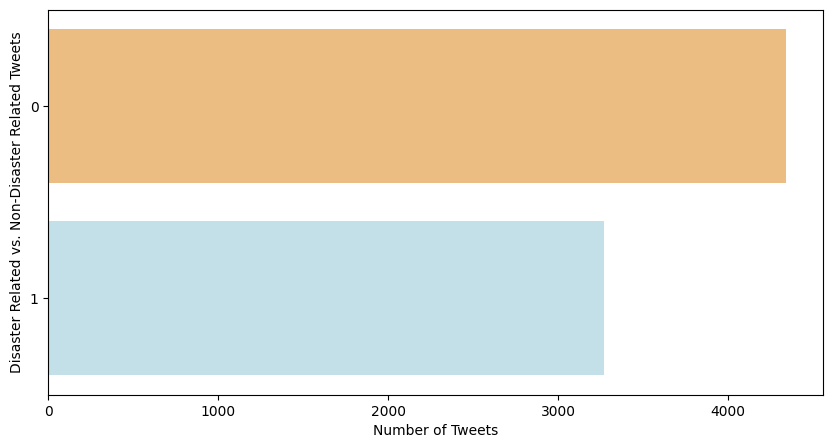

In [18]:
#Visualizing class distribution
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data,palette="RdYlBu")
plt.ylabel("Disaster Related vs. Non-Disaster Related Tweets")
plt.xlabel("Number of Tweets")
plt.show()

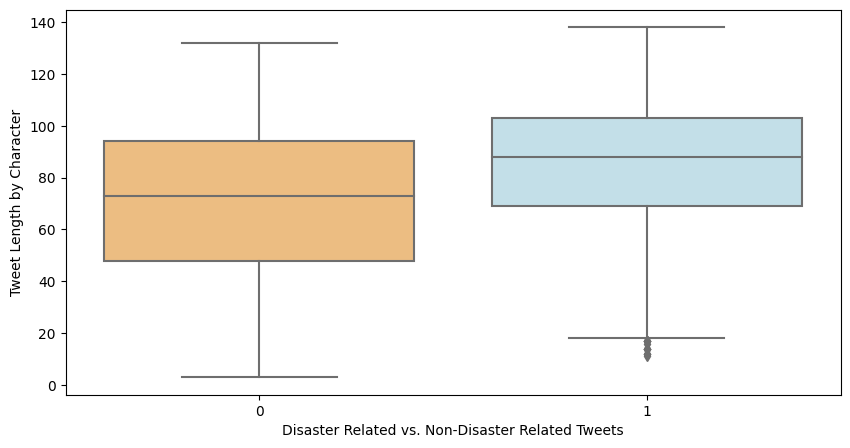

In [19]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="RdYlBu")
plt.xlabel("Disaster Related vs. Non-Disaster Related Tweets")
plt.ylabel("Tweet Length by Character")
plt.show()

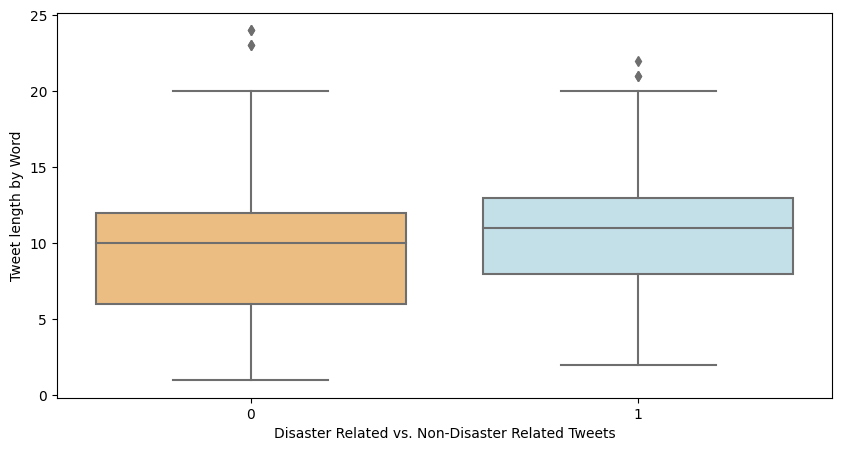

In [20]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="RdYlBu")
plt.xlabel("Disaster Related vs. Non-Disaster Related Tweets")
plt.ylabel("Tweet length by Word")
plt.show()

In [21]:
# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

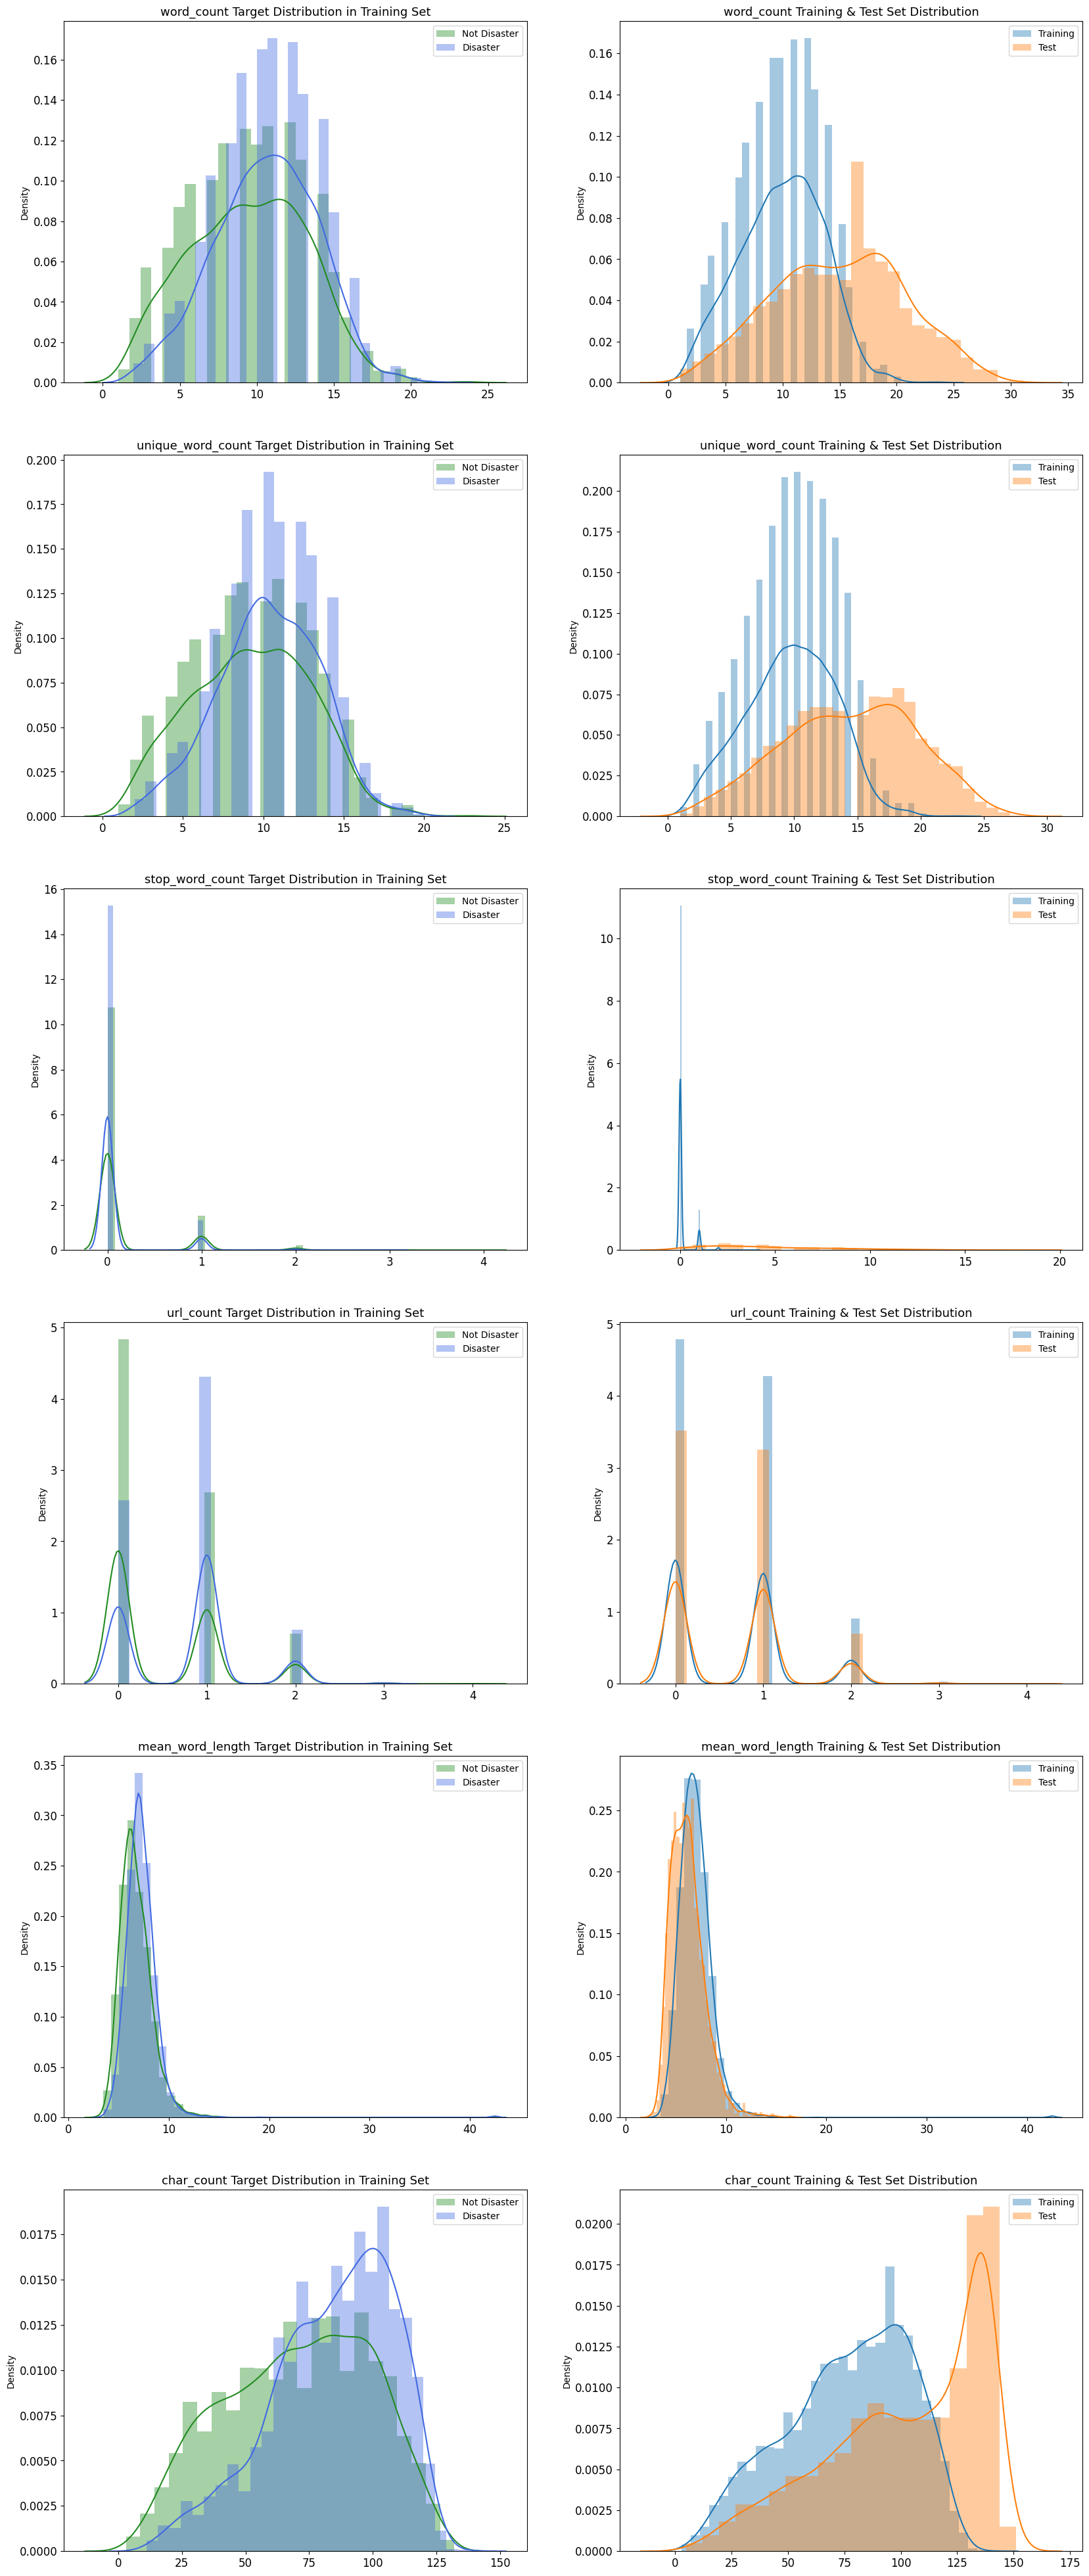

In [22]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='forestgreen')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='royalblue')

    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

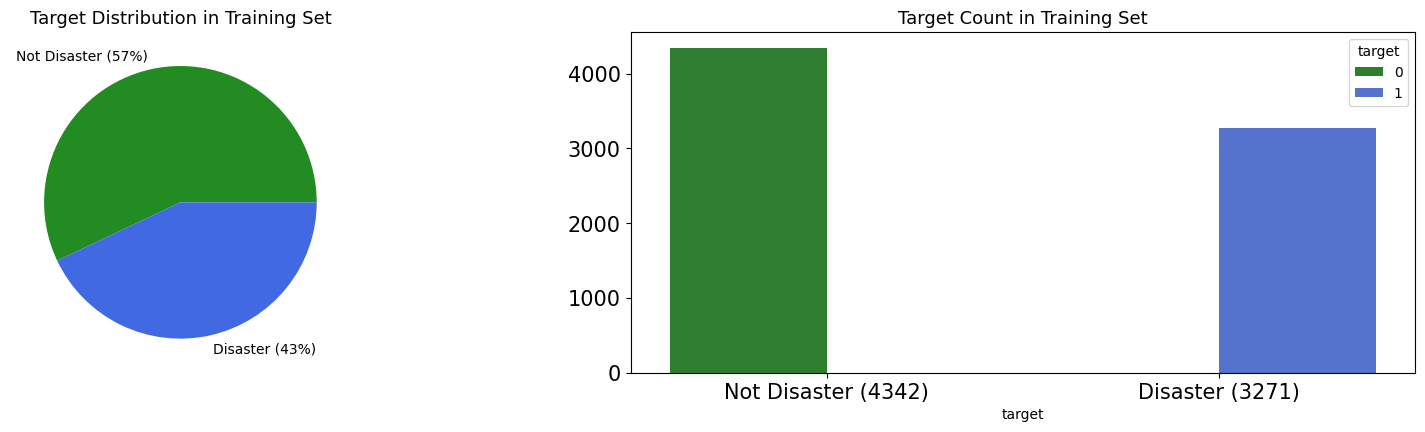

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

# Define custom colors for the pie chart and countplot
pie_colors = ['forestgreen', 'royalblue']  # Custom colors for the pie chart
countplot_colors = ['forestgreen', 'royalblue']  # Custom colors for the countplot

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'], colors=pie_colors)
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1], palette=countplot_colors)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)



plt.show()

**BERT - Bidirectional Encoder Representations from Transformers**

* BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

* The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.

**LOADING THE BERT MODEL:**

In [24]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
tokenizer('NLP is my favourite class in the MSBA programme &*&*&&')

{'input_ids': [101, 17953, 2361, 2003, 2026, 8837, 2465, 1999, 1996, 5796, 3676, 4746, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**CONVERSION OF OUR TEXT DATA INTO BERT INPUT FORMAT:**

In [26]:
print("max len of tweets",max([len(x.split()) for x in train_data.text]))

max len of tweets 24


In [27]:
max_length = 36

In [28]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [29]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [30]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [31]:
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**BUILDING THE MODEL ARCHITECTURE:**

In [33]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")


embeddings = bert(input_ids,attention_mask = input_mask)[1]
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      
                             hidden_state=(None, 36, 10                                       

In [35]:
initial_learning_rate = 6e-06
decay_rate = 0.01
optimizer = Adam(learning_rate=initial_learning_rate, epsilon=1e-08, clipnorm=1.0)

# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=decay_rate, staircase=True)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),

# Compile the model with the optimizer and learning rate schedule
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [39]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=4,
    batch_size=64
)

Epoch 1/4
119/119 [==============================] - 181s 2s/step - loss: 0.1180 - accuracy: 0.9581
Epoch 2/4
119/119 [==============================] - 181s 2s/step - loss: 0.0993 - accuracy: 0.9623
Epoch 3/4
119/119 [==============================] - 181s 2s/step - loss: 0.0885 - accuracy: 0.9673
Epoch 4/4
119/119 [==============================] - 181s 2s/step - loss: 0.0747 - accuracy: 0.9731


**VISUALIZATION OF LOSS AND ACCURACY CURVE:**

In [40]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

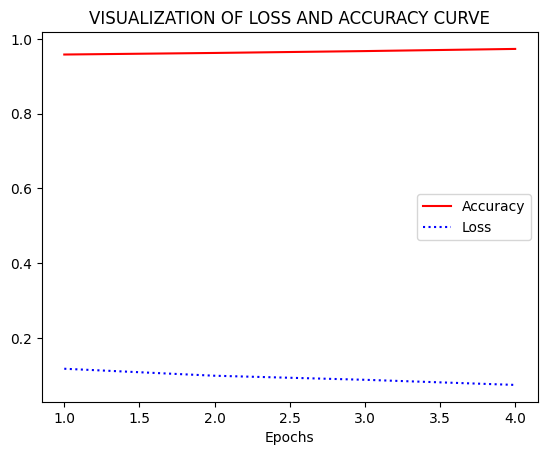

In [41]:
visual_accuracy_and_loss(final)

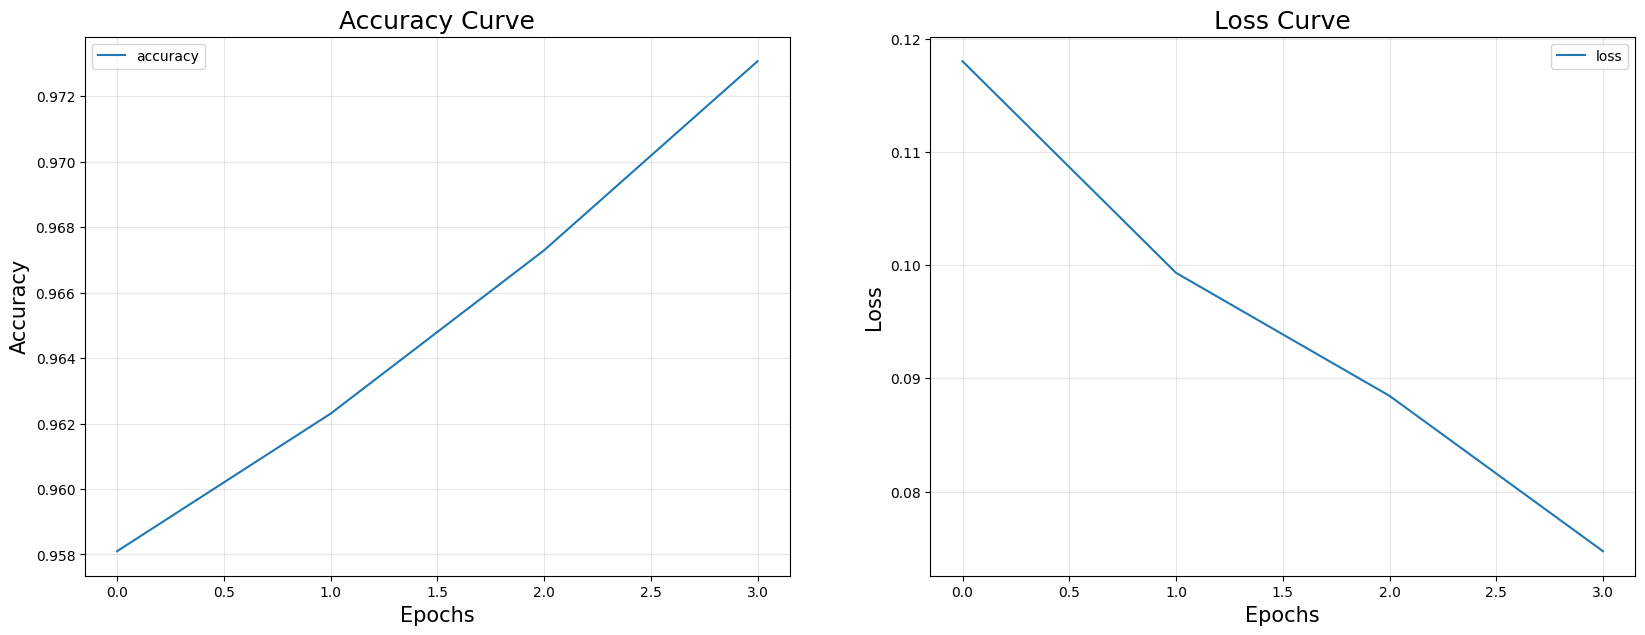

In [42]:
# Plot the loss and accuracy curves

#Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") # Accuracy curve


plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") # Loss curve


plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


In [43]:
test_data

,id,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,0,Just happened a terrible car crash,6,6,2,0,4.833333,34
1,2,"Heard about #earthquake is different cities, s...",9,9,2,0,6.222222,64
2,3,"there is a forest fire at spot pond, geese are...",19,19,10,0,4.105263,96
3,9,Apocalypse lighting. #Spokane #wildfires,4,4,0,0,9.250000,40
4,11,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,4.750000,45
...,...,...,...,...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8,7,0,0,6.000000,55
3259,10865,Storm in RI worse than last hurricane. My city...,23,22,7,0,5.086957,139
3260,10868,Green Line derailment in Chicago http://t.co/U...,6,6,1,1,8.333333,55
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,7,7,0,1,8.428571,65


In [44]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

**PREDICTION:**

In [50]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

102/102 [==============================] - 28s 278ms/step


In [52]:
y_predicted = np.where(predicted>0.5,1,0)

In [51]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [53]:
y_predicted

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [56]:
# Ensure y_predicted is a 1-dimensional array
y_predicted = np.squeeze(y_predicted)  # Convert to 1-dimensional array

# Reshape y_predicted to match the length of your test data
y_predicted = y_predicted[:len(test_data)]  # Ensure y_predicted has the same length as test_data

# Creating a DataFrame with predictions
predictions_df = pd.DataFrame({
    'id': test_data['id'],
    'text': test_data['text'],
    'prediction': y_predicted
})
predictions_df.head()

,id,text,prediction
0,0,Just happened a terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",1
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1


In [57]:
predictions_df['prediction'].value_counts()

0    2030
1    1233
Name: prediction, dtype: int64

238/238 [==============================] - 84s 271ms/step


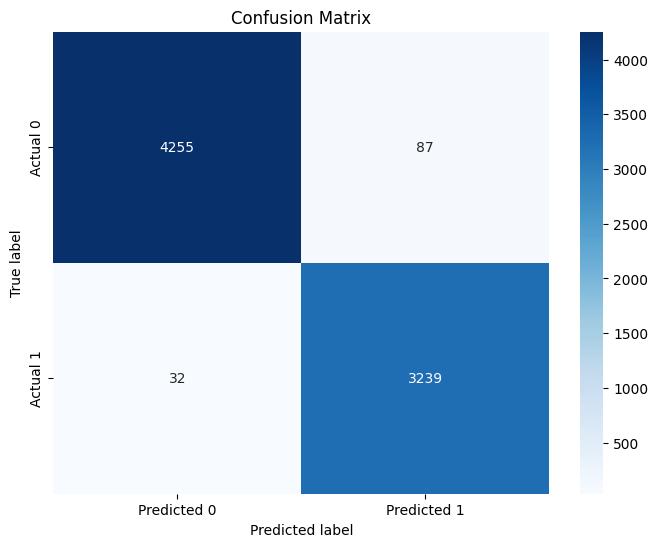

In [62]:
# Generate predictions using the model
train_predictions = model.predict([x_train['input_ids'], x_train['attention_mask']])

# Round predictions to 0 or 1 based on the threshold of 0.5
train_predictions_rounded = np.where(train_predictions > 0.5, 1, 0)

# Assuming 'train_actual_values' is your actual target values from train_data
train_actual_values = train_data['target']  # Replace 'target' with the appropriate column name

# Create a confusion matrix
conf_matrix = confusion_matrix(train_actual_values, train_predictions_rounded)

# Convert the confusion matrix to a DataFrame for better visualization
confusion_df = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

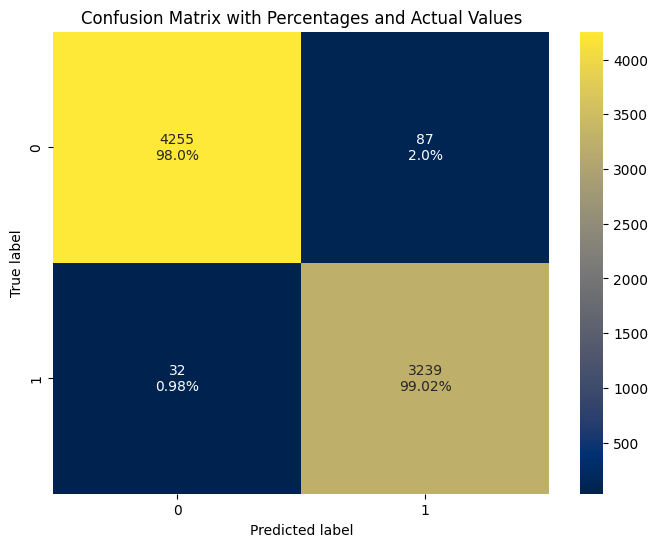

In [99]:
# Create a confusion matrix
conf_matrix = confusion_matrix(train_actual_values, train_predictions_rounded)

# Calculate percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a DataFrame with both percentages and actual values as annotations
confusion_df = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
confusion_df_percent = confusion_df.astype(str) + '\n' + conf_matrix_percent.round(2).astype(str) + '%'

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=confusion_df_percent, fmt='', cmap='cividis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix with Percentages and Actual Values')
plt.show()

In [67]:
predictions_df = text_preprocessing(predictions_df,'text')

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

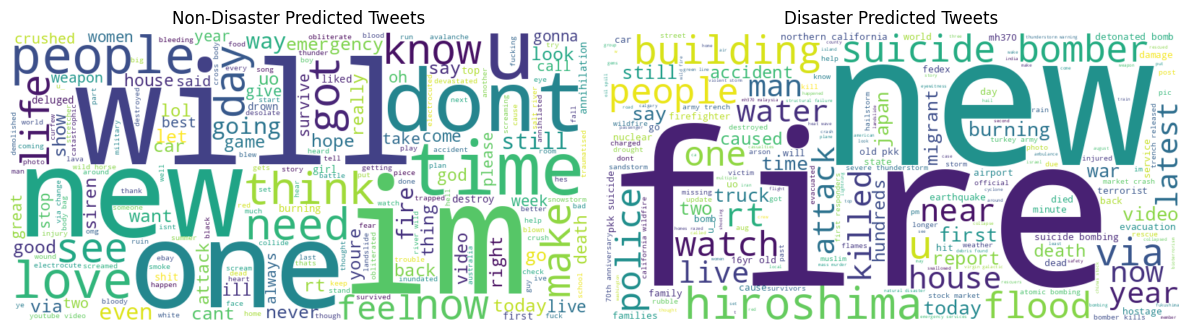

In [68]:
# Extract non-disaster and disaster predicted tweets based on 'prediction' column
non_disaster_tweets = predictions_df[predictions_df['prediction'] == 0]['text']
disaster_tweets = predictions_df[predictions_df['prediction'] == 1]['text']

# Join non-disaster and disaster tweets into single strings
non_disaster_text = ' '.join(non_disaster_tweets)
disaster_text = ' '.join(disaster_tweets)

# Generate WordCloud for non-disaster predicted tweets
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Generate WordCloud for disaster predicted tweets
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)

# Plotting the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Predicted Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Predicted Tweets')
plt.axis('off')

plt.tight_layout()
plt.show()


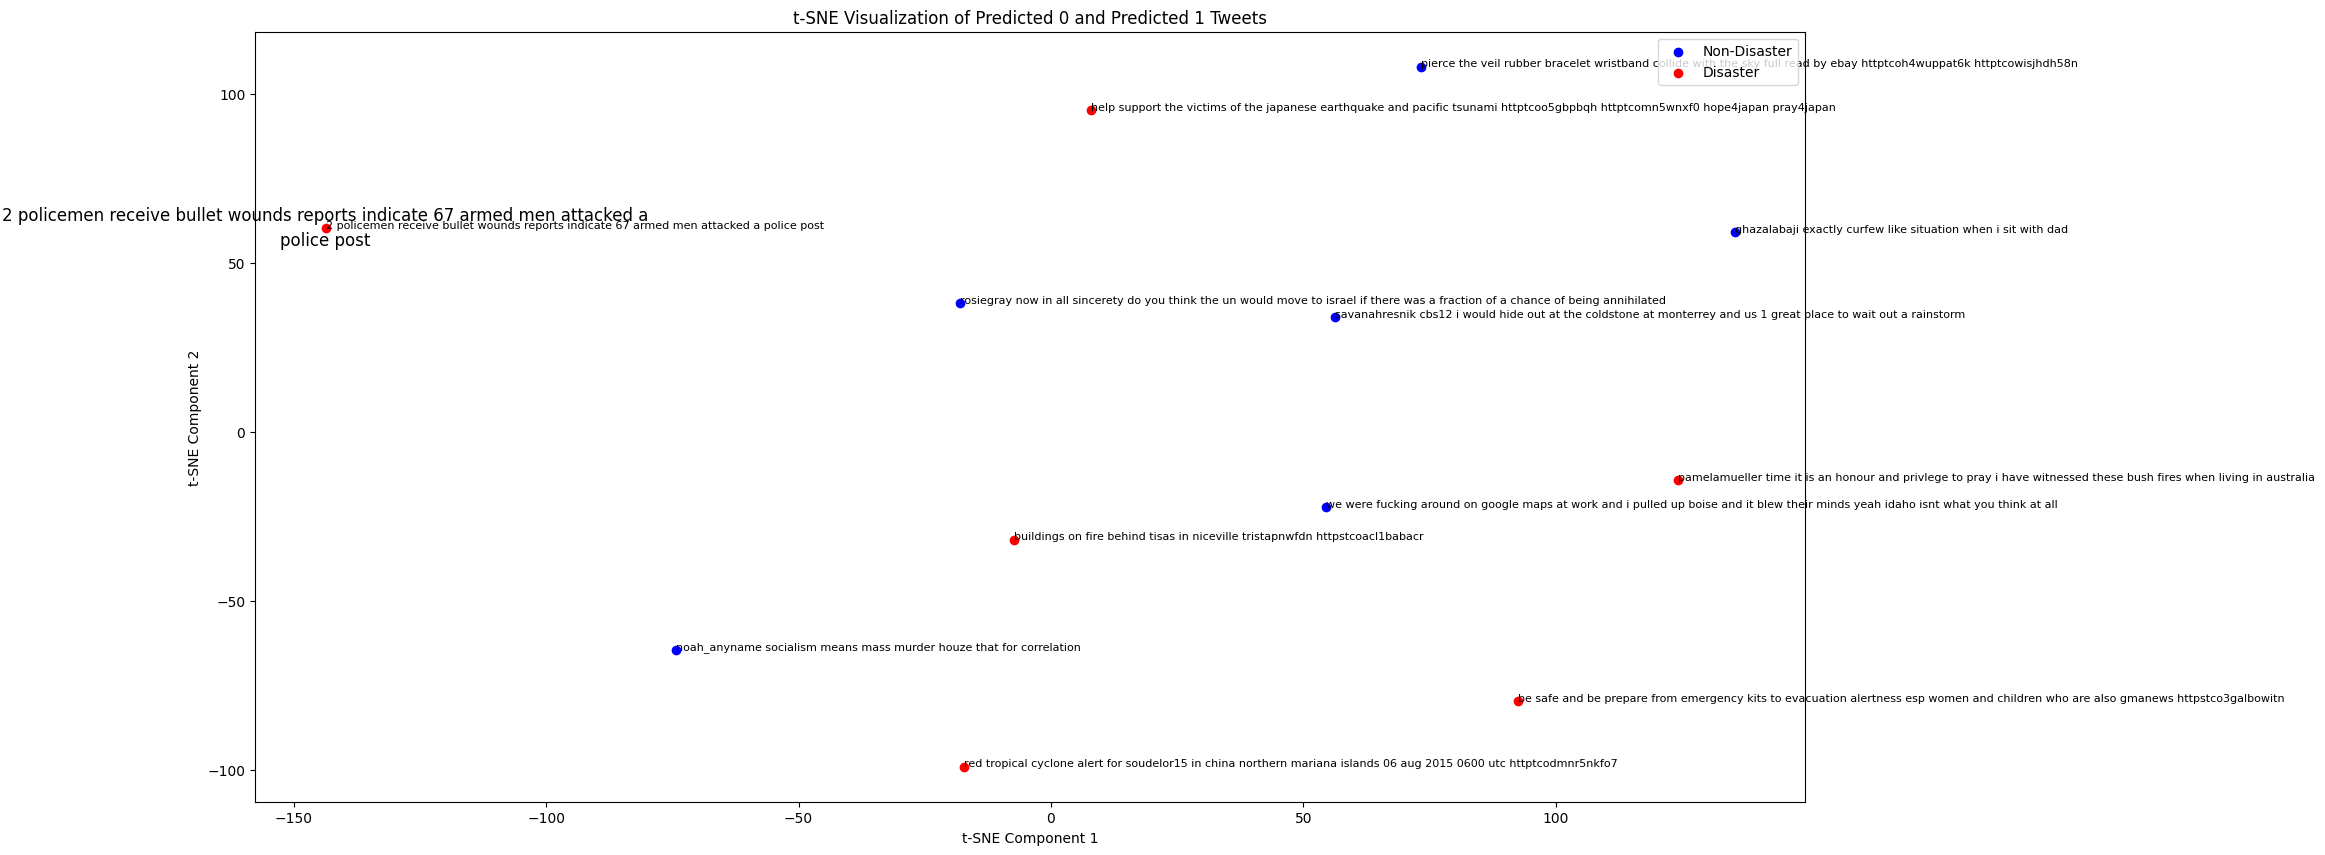

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import random

# Filter test_data for predicted 0 and predicted 1 tweets
predicted_0_tweets = predictions_df[predictions_df['prediction'] == 0]['text']
predicted_1_tweets = predictions_df[predictions_df['prediction'] == 1]['text']

# Take a random sample of 6 tweets for predicted 0 and 1 tweets for predicted 1
random.seed(42)  # Set seed for reproducibility
sample_predicted_0 = random.sample(predicted_0_tweets.tolist(), 6)
sample_predicted_1 = random.sample(predicted_1_tweets.tolist(), 6)

# Combine the sampled tweets for processing
combined_sample = sample_predicted_0 + sample_predicted_1

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_sample)

# Apply t-SNE for dimensionality reduction with lower perplexity and random initialization
tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='random')
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to array

# Plotting the t-SNE visualization
plt.figure(figsize=(20, 10))
for i, label in enumerate(combined_sample):
    x, y = tsne_result[i, :]
    plt.scatter(x, y, marker='o', color='blue' if i < len(sample_predicted_0) else 'red')
    plt.text(x, y, label, fontsize=8)

plt.scatter([], [], color='blue', label='Non-Disaster')
plt.scatter([], [], color='red', label='Disaster')
plt.legend()

plt.title('t-SNE Visualization of Predicted 0 and Predicted 1 Tweets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.text(x, y, label, fontsize=12, ha='center', va='center', wrap=True, linespacing=1.5)
plt.show()
